In [1]:
import sys
sys.path.append("..")

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from time import localtime, strftime
from D2.data_selector import DataSelector

SEED = 42

In [2]:
ds = DataSelector("../D2/data.csv")
data = ds.select_data(30000, length=5, scale_sd=1.5, seed=SEED)
data['conversation'] = data['conversation'].astype(str)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/VAD/M1.5/../D2/data_selector.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filepath)


Filtering...
Calculating counts...
Grabbing data...


array([[<Axes: title={'center': 'V'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'D'}>, <Axes: >]], dtype=object)

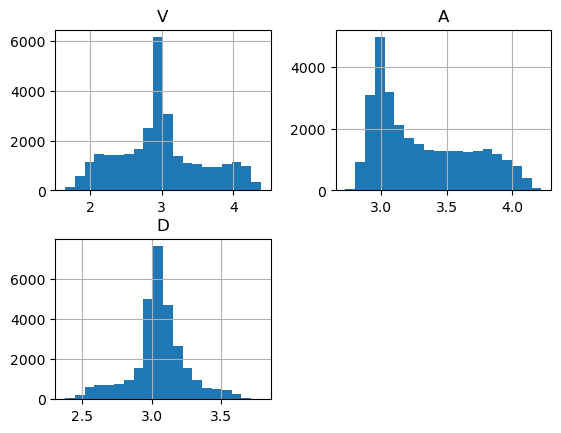

In [3]:
data.hist(bins=20)

In [4]:
raw_dataset = Dataset.from_pandas(data)
train_testval = raw_dataset.train_test_split(test_size=0.2, seed=SEED)
test_val = train_testval['test'].train_test_split(test_size=0.5, seed=SEED)

dataset = DatasetDict({
    'train': train_testval['train'],
    'test': test_val['test'],
    'val': test_val['train']})


In [5]:
dataset['train'][0]

{'text': ["hahahaha you're such a dork, OMG OMG OMG I THINK TWITTER IS TALKING TO ME",
  '￼',
  'what are you showing me here ingrid??',
  "It's just a pretty house in w Philly that I just walked by , ￼, That's what I'm doing",
  "oh they're cute! you both are!"],
 'conversation': '14749',
 'source': 'Bolt',
 'V': 4.195347785949707,
 'A': 3.931572198867798,
 'D': 3.125108242034912,
 '__index_level_0__': 516081}

In [6]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def mask_data(mask_ratio):
    def mask_function(examples):
        mask_idx = np.random.choice(len(examples), int(mask_ratio * len(examples)), replace=False)
        convs = examples["text"]
        for i in mask_idx:
            convs[i][-1] = tokenizer.mask_token
        
        return {"text": convs}

    return mask_function

def preprocess_data(examples):
    role_names = ("speaker", "respondent")

    convs = [
        tokenizer.apply_chat_template(
            [{"role": role_names[i % 2], "content": x} for i, x in enumerate(m)], 
            tokenize=False)
        for m in examples["text"]
    ]

    encoding = tokenizer(convs, max_length=512, truncation=True)
    encoding["labels"] = list(zip(examples["V"], examples["A"], examples["D"]))

    return encoding

dataset["train"] = dataset["train"].map(mask_data(0.5), batched=True, batch_size=100000)
tokenized_dataset = dataset.map(preprocess_data, batched=True, batch_size=100000)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [7]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = 4/(1+np.exp(-logits)) + 1

    metrics = {
        "mae": mean_absolute_error(labels, logits, multioutput="raw_values").tolist(),
        "mse": mean_squared_error(labels, logits, multioutput="raw_values").tolist(),
        "pearsonr": [pearsonr(logits[:, i], labels[:, i])[0] for i in range(len(logits[0]))],
        "r_squared": r2_score(labels, logits, multioutput="raw_values").tolist(),
    }

    return {f"{m}_{s}": metrics[m][i] for i, s in enumerate("VAD") for m in metrics}

In [9]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs['logits']) * 4 + 1
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [10]:
raise Exception

Exception: 

In [11]:
dir_name = strftime("%b-%d-%y-%H:%M:%S", localtime())

training_args = TrainingArguments(
    output_dir=f"results/{dir_name}",
    logging_dir=f"results/{dir_name}/runs",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-6,
    max_grad_norm=1.0,
    num_train_epochs=20,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    disable_tqdm=True
)

trainer = RegressionTrainer(
    model_init=get_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/15000 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.1802, 'learning_rate': 1e-06, 'epoch': 1.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.08177849650382996, 'eval_mae_V': 0.29825359582901, 'eval_mse_V': 0.14983096718788147, 'eval_pearsonr_V': 0.7833742509738766, 'eval_r_squared_V': 0.5695901736505593, 'eval_mae_A': 0.19874534010887146, 'eval_mse_A': 0.0684344619512558, 'eval_pearsonr_A': 0.6947840347095483, 'eval_r_squared_A': 0.4760083597723649, 'eval_mae_D': 0.11681410670280457, 'eval_mse_D': 0.027070052921772003, 'eval_pearsonr_D': 0.5999608215853289, 'eval_r_squared_D': 0.34433874337903425, 'eval_runtime': 12.4163, 'eval_samples_per_second': 241.618, 'eval_steps_per_second': 7.571, 'epoch': 1.0}
{'loss': 0.0454, 'learning_rate': 2e-06, 'epoch': 2.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.029978515580296516, 'eval_mae_V': 0.15658755600452423, 'eval_mse_V': 0.049929387867450714, 'eval_pearsonr_V': 0.9508002054701707, 'eval_r_squared_V': 0.8565711186843789, 'eval_mae_A': 0.12752951681613922, 'eval_mse_A': 0.03041193075478077, 'eval_pearsonr_A': 0.9440961249103715, 'eval_r_squared_A': 0.767140500413682, 'eval_mae_D': 0.06835902482271194, 'eval_mse_D': 0.009594237431883812, 'eval_pearsonr_D': 0.9075338693244422, 'eval_r_squared_D': 0.7676190998159276, 'eval_runtime': 12.3695, 'eval_samples_per_second': 242.532, 'eval_steps_per_second': 7.599, 'epoch': 2.0}
{'loss': 0.0231, 'learning_rate': 1.8888888888888888e-06, 'epoch': 3.0}


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.016352366656064987, 'eval_mae_V': 0.12004595249891281, 'eval_mse_V': 0.03010144643485546, 'eval_pearsonr_V': 0.9698115831986066, 'eval_r_squared_V': 0.9135295918855604, 'eval_mae_A': 0.08161598443984985, 'eval_mse_A': 0.013371462933719158, 'eval_pearsonr_A': 0.9673548783240942, 'eval_r_squared_A': 0.8976167456104558, 'eval_mae_D': 0.05269442871212959, 'eval_mse_D': 0.005584199912846088, 'eval_pearsonr_D': 0.9409532452965963, 'eval_r_squared_D': 0.86474550276606, 'eval_runtime': 12.4597, 'eval_samples_per_second': 240.777, 'eval_steps_per_second': 7.544, 'epoch': 3.0}


: 